In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [2]:
class Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 11, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 11, stride = 1, padding = 1),
            nn.ReLU(),
            nn.AvgPool2d(6,6),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(12544,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,192*192)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [3]:
model = nn.DataParallel(Classification())
model.load_state_dict(torch.load('./model/cnn.pth'))

<All keys matched successfully>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
model.to(device)

DataParallel(
  (module): Classification(
    (network): Sequential(
      (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): AvgPool2d(kernel_size=6, stride=6, padding=0)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (15): Flatten(start_dim=1, end_dim=-1)
      (16): Linear(in_features=12544, out_features=1024, bias=True)
    

In [6]:
def isListEmpty(inList):
    if isinstance(inList, list): # Is a list
        return all( map(isListEmpty, inList) )
    return False # Not a list

In [9]:
import numpy as np
import os
from PIL import Image
path = 'data/ACDC/test'

file_name = 'patient010_frame13_7.jpg'


x = np.zeros((64, 64), dtype="float32")
y = np.zeros((64, 64), dtype="float32")

images = cv2.imread(os.path.join(path, 'images', file_name), cv2.IMREAD_GRAYSCALE)
images = images/255.0

img = images.reshape(1, 1, images.shape[0], images.shape[1])
    
target = cv2.imread(os.path.join(path, 'mask', file_name))


img = torch.from_numpy(img)

img = img.float()

out = model(img)

out = out.cpu().detach().numpy()
    
where = np.array(np.where(out.reshape(192, 192) > 0.5))

if isListEmpty(where):
    x = cv2.resize(images, (64, 64), interpolation = cv2.INTERSECT_NONE)
    y = cv2.resize(target, (64, 64), interpolation = cv2.INTERSECT_NONE)
try:
    X_min, Y_min = np.amin(where, axis=1)
    X_max, Y_max = np.amax(where, axis=1)
except:
    x = cv2.resize(images, (64, 64), interpolation = cv2.INTERSECT_NONE)
    y = cv2.resize(target, (64, 64), interpolation = cv2.INTERSECT_NONE)

X_middle = X_min + (X_max - X_min) / 2
Y_middle = Y_min + (Y_max - Y_min) / 2

X_top = int(X_middle - 50)
Y_top = int(Y_middle - 50)
X_down = int(X_middle + 50 )
Y_down = int(Y_middle + 50 )


if X_top <= 0:
    X_down = X_down + (100 - (X_down - X_top)) - X_top
    X_top = 0

if Y_top <= 0:
    Y_down = Y_down + (100 - (Y_down - Y_top)) - Y_top
    Y_top = 0

if X_down > 191:
    X_top = X_top + (191 - X_down)
    X_down = 191

if Y_down > 191:
    Y_top = Y_top + (191- Y_down)
    Y_down = 191
images = cv2.imread(os.path.join(path, 'images', file_name), cv2.IMREAD_GRAYSCALE)
x_t = images[X_top:X_down, Y_top:Y_down]
x = cv2.resize(x_t,(64 , 64))

y_t = target[X_top:X_down, Y_top:Y_down]
y = cv2.resize(y_t,(64 , 64), interpolation = cv2.INTERSECT_NONE)

Text(0.5, 1.0, 'Input Mask')

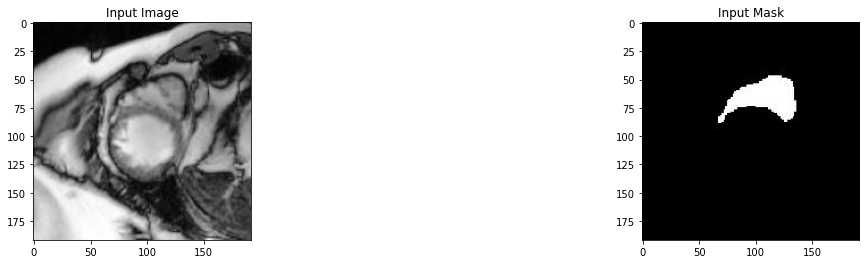

In [11]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(ncols=2, figsize=(20,4))

ax[0].imshow(images, cmap='gray')
ax[0].set_title('Input Image')
ax[1].imshow(target, cmap='gray')
ax[1].set_title('Input Mask')

Text(0.5, 1.0, 'Corresponding Target Map')

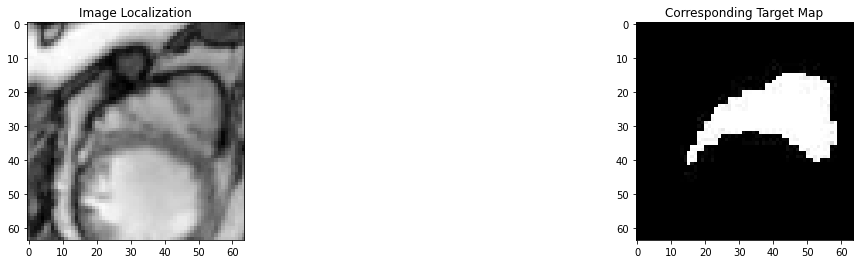

In [14]:
f, ax = plt.subplots(ncols=2, figsize=(20,4))

ax[0].imshow(x, cmap='gray')
ax[0].set_title('Image Localization')
ax[1].imshow(y, cmap='gray')
ax[1].set_title('Corresponding Target Map')

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, Concatenate

class UnetUtils():
    
    """ 
    Unet Model design utillities framework.
    
    This module provides a convenient way to create different layers/blocks
    which the UNet network is based upon. It consists of a contracting
    path and an expansive path. Both these paths are joined by a bottleneck block.
    
    The different blocks involved in the design of the network can be referenced @ 
    U-Net: Convolutional Networks for Biomedical Image Segmentation
    
    Source:
        https://arxiv.org/pdf/1505.04597
    """
    
    def __init__(self):
        pass
    
    def contracting_block(self, input_layer, filters, padding, kernel_size = 3):
        
        """ 
        UNet Contracting block
        Perform two unpadded convolutions with a specified number of filters and downsample
        through max-pooling.
        
        Args:
            input_layer: the input layer on which the current layers should work upon.
            filters (int): Number of filters in convolution.
            kernel_size (int/tuple): Index of block. Default is 3.
            padding ("valid" or "same"): Default is "valid" (no padding involved).
            
        Return:
            Tuple of convolved ``inputs`` after and before downsampling
        """
        
        # two 3x3 convolutions (unpadded convolutions), each followed by
        # a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
        # for downsampling.
        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      activation = tf.nn.relu, 
                      padding = padding)(input_layer)

        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      activation = tf.nn.relu, 
                      padding = padding)(conv)

        pool = MaxPooling2D(pool_size = 2, 
                            strides = 2)(conv)

        return conv, pool

    def bottleneck_block(self, input_layer, filters, padding, kernel_size = 3, strides = 1):
        
        """ 
        UNet bottleneck block
        
        Performs 2 unpadded convolutions with a specified number of filters.
        
        Args:
            input_layer: the input layer on which the current layers should work upon.
            filters (int): Number of filters in convolution.
            kernel_size (int/tuple): Index of block. Default is 3.
            padding ("valid" or "same"): Default is "valid" (no padding involved).
            strides: An integer or tuple/list of 2 integers, specifying the strides 
                     of the convolution along the height and width. Default is 1.
        Return:
            The convolved ``inputs``.
        """
        
        # two 3x3 convolutions (unpadded convolutions), each followed by
        # a rectified linear unit (ReLU)
        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      padding = padding,
                      strides = strides, 
                      activation = tf.nn.relu)(input_layer)

        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      padding = padding,
                      strides = strides, 
                      activation = tf.nn.relu)(conv)

        return conv

    def expansive_block(self, input_layer, skip_conn_layer, filters, padding, kernel_size = 3, strides = 1):
        
        """ 
        UNet expansive (upsample) block.
        
        Transpose convolution which doubles the spatial dimensions (height and width) 
        of the incoming feature maps and creates the skip connections with the corresponding 
        feature maps from the contracting (downsample) path. These skip connections bring the feature maps 
        from earlier layers helping the network to generate better semantic feature maps.
        
        Perform two unpadded convolutions with a specified number of filters 
        and upsamples the incomming feature map.
        
        Args:
            input_layer: the input layer on which the current layers should work upon.
            skip_connection: The feature map from the contracting (downsample) path from which the 
                             skip connection has to be created.
            filters (int): Number of filters in convolution.
            kernel_size (int/tuple): Index of block. Default is 3.
            padding ("valid" or "same"): Default is "valid" (no padding involved).
            strides: An integer or tuple/list of 2 integers, specifying the strides 
                     of the convolution along the height and width. Default is 1.
                     
        Return:
            The upsampled feature map.
        """
        
        # up sample the feature map using transpose convolution operations.
        transConv = Conv2DTranspose(filters = filters, 
                                    kernel_size = (2, 2),
                                    strides = 2, 
                                    padding = padding)(input_layer)
        
        # crop the source feature map so that the skip connection can be established.
        # the original paper implemented unpadded convolutions. So cropping is necessary 
        # due to the loss of border pixels in every convolution.
        # establish the skip connections.
        if padding == "valid":
            cropped = self.crop_tensor(skip_conn_layer, transConv)
            concat = Concatenate()([transConv, cropped])
        else:
            concat = Concatenate()([transConv, skip_conn_layer])
        
        # two 3x3 convolutions, each followed by a ReLU
        up_conv = Conv2D(filters = filters, 
                         kernel_size = kernel_size, 
                         padding = padding, 
                         activation = tf.nn.relu)(concat)

        up_conv = Conv2D(filters = filters, 
                         kernel_size = kernel_size, 
                         padding = padding, 
                         activation = tf.nn.relu)(up_conv)

        return up_conv
    
    def crop_tensor(self, source_tensor, target_tensor):
        
        """
        Center crops the source tensor to the size of the target tensor size.
        The tensor shape format is [batchsize, height, width, channels]
        
        Args:
            source_tensor: the tensor that is to be cropped.
            target_tensor: the tensor to whose size the 
                           source needs to be cropped to.
                           
        Return:
            the cropped version of the source tensor.
        
        """
        
        target_tensor_size = target_tensor.shape[2]
        source_tensor_size = source_tensor.shape[2]
        
        # calculate the delta to ensure correct cropping.
        delta = source_tensor_size - target_tensor_size
        delta = delta // 2
        
        cropped_source = source_tensor[:, delta:source_tensor_size - delta, delta:source_tensor_size - delta, :]
        
        return cropped_source

2023-05-06 08:59:06.763482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 08:59:07.076218: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-06 08:59:09.073737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home2/sashank.sridhar/miniconda3/envs/TripletLoss/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-10.2/lib64:/opt/cudnn-7.6.5.32-cuda-10.2/lib64
2023-05-06 08:59:09.073907: W tensorflow/stream_execut

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
UnetUtils = UnetUtils()

class Unet():
    
    """ 
    Unet Model design.
    
    This module consumes the Unet utilities framework moule and designs the Unet network.
    It consists of a contracting path and an expansive path. Both these paths are joined 
    by a bottleneck block.
    
    The different blocks involved in the design of the network can be referenced @ 
    U-Net: Convolutional Networks for Biomedical Image Segmentation
    
    Source:
        https://arxiv.org/pdf/1505.04597
    """
    
    def __init__(self, input_shape = (572, 572, 1), filters = [64, 128, 256, 512, 1024], padding = "valid"):
        """
        
        Initialize the Unet framework and the model parameters - input_shape, 
        filters and padding type. 
        
        Args:
            input_shape: The shape of the input to the network. A tuple comprising of (img_height, img_width, channels).
                         Original paper implementation is (572, 572, 1).
            filters: a collection of filters denoting the number of components to be used at each blocks along the 
                     contracting and expansive paths. The original paper implementation for number of filters along the 
                     contracting and expansive paths are [64, 128, 256, 512, 1024].
            padding: the padding type to be used during the convolution step. The original paper used unpadded convolutions 
                     which is of type "valid".
         
        **Remarks: The default values are as per the implementation in the original paper @ https://arxiv.org/pdf/1505.04597
        
        """
        self.input_shape = input_shape
        self.filters = filters
        self.padding = padding
    
    def Build_UNetwork(self):
        
        """
        Builds the Unet Model network.
        
        Args:
            None
         
        Return:
            The Unet Model.
            
        """

        
        UnetInput = Input(self.input_shape)
        
        # the contracting path. 
        # the last item in the filetrs collection points to the number of filters in the bottleneck block.
        conv1, pool1 = UnetUtils.contracting_block(input_layer = UnetInput, filters = self.filters[0], padding = self.padding)
        conv2, pool2 = UnetUtils.contracting_block(input_layer = pool1, filters = self.filters[1], padding = self.padding)
        conv3, pool3 = UnetUtils.contracting_block(input_layer = pool2, filters = self.filters[2], padding = self.padding)
        conv4, pool4 = UnetUtils.contracting_block(input_layer = pool3, filters = self.filters[3], padding = self.padding)
        
        # bottleneck block connecting the contracting and the expansive paths.
        bottleNeck = UnetUtils.bottleneck_block(pool4, filters = self.filters[4], padding = self.padding)

        # the expansive path.
        upConv1 = UnetUtils.expansive_block(bottleNeck, conv4, filters = self.filters[3], padding = self.padding) 
        upConv2 = UnetUtils.expansive_block(upConv1, conv3, filters = self.filters[2], padding = self.padding) 
        upConv3 = UnetUtils.expansive_block(upConv2, conv2, filters = self.filters[1], padding = self.padding) 
        upConv4 = UnetUtils.expansive_block(upConv3, conv1, filters = self.filters[0], padding = self.padding) 

        UnetOutput = Conv2D(1, (1, 1), padding = self.padding, activation = tf.math.sigmoid)(upConv4)
        
        model = Model(UnetInput, UnetOutput, name = "UNet")
        
        return model

    def CompileAndSummarizeModel(self, model, optimizer = "adam", loss = "binary_crossentropy"):
        
        """
        Compiles and displays the model summary of the Unet model.
        
        Args:
            model: The Unet model.
            optimizer: model optimizer. Default is the adam optimizer.
            loss: the loss function. Default is the binary cross entropy loss.
            
        Return:
            None
        
        """
        model.compile(optimizer=Adam(1e-4, decay=1e-6), loss="binary_crossentropy", metrics=[dice_coef])
        model.summary()
        
    def plotModel(self, model, to_file = 'unet.png', show_shapes = True, dpi = 96):
        
        """
        Saves the Unet model to a file.
        
        Args:
            model: the Unet model. 
            to_file: the file name to save the model. Default name - 'unet.png'.
            show_shapes: whether to display shape information. Default = True.
            dpi: dots per inch. Default value is 96.
            
        Return:
            None
        
        """
        
        tf.keras.utils.plot_model(model, to_file = to_file, show_shapes = show_shapes, dpi = dpi)

In [18]:
unet = Unet(input_shape = (64, 64, 1), 
            filters = [16, 32, 64, 128, 256], 
            padding = "same")

# call the build netowrk API to build the network.
model = unet.Build_UNetwork()

2023-05-06 08:59:29.954941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home2/sashank.sridhar/miniconda3/envs/TripletLoss/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-10.2/lib64:/opt/cudnn-7.6.5.32-cuda-10.2/lib64
2023-05-06 08:59:29.954991: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-06 08:59:29.955394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in p

In [19]:

from keras.models import model_from_json
from keras.models import load_model

# load json and create model
json_file = open('./model/unet.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./model/unet.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
predicted_masks = loaded_model.predict(x.reshape(1, 64, 64))
# print(predicted_masks[0])
op = np.zeros((64, 64))
for i in range(0, len(predicted_masks[0])):
    for j in range(0, len(predicted_masks[0])):
#         print(predicted_masks[0][i][j][0])
        if predicted_masks[0][i][j][0] > 0.15:
            op[i][j] = 255
        else:
            op[i][j] = 0


1/1 [==============================] - 0s 305ms/step


Text(0.5, 1.0, 'Mask Predicted')

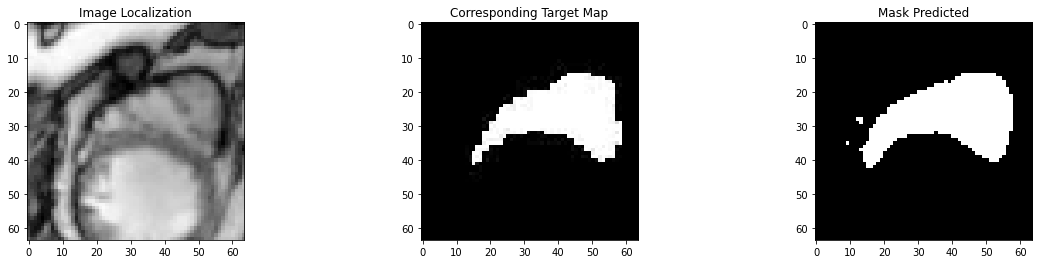

In [23]:
f, ax = plt.subplots(ncols=3, figsize=(20,4))

ax[0].imshow(x, cmap='gray')
ax[0].set_title('Image Localization')
ax[1].imshow(y, cmap='gray')
ax[1].set_title('Corresponding Target Map')
ax[2].imshow(op, cmap='gray')
ax[2].set_title('Mask Predicted')

Text(0.5, 1.0, 'After Deforming')

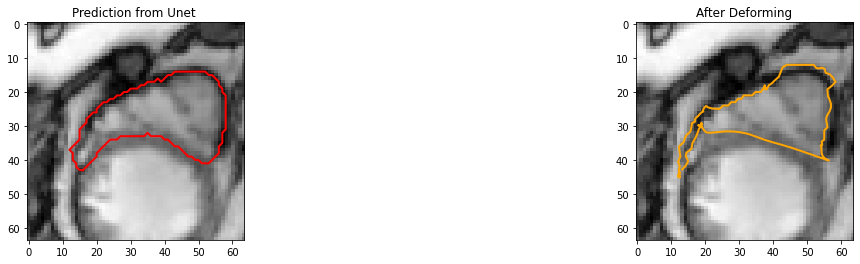

In [26]:
from skimage.segmentation import chan_vese, active_contour

from skimage import measure
contours_pred = measure.find_contours(op, 0.8)
contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]
img = x.reshape((64,64))
ac_contour = active_contour(img, contour_pred, alpha=0.01, beta=1)
f, ax = plt.subplots(ncols=2, figsize=(20,4))

ax[0].imshow(img, cmap='gray')
ax[0].plot(contour_pred[:, 1], contour_pred[:, 0], linewidth=2, color='red',label='Prediction')
ax[0].set_title('Prediction from Unet ')
ax[1].imshow(img, cmap='gray')

ax[1].plot(ac_contour[:, 1], ac_contour[:, 0], linewidth=2, color='orange',label='Prediction')
ax[1].set_title('After Deforming')